# **Image and Bounding Box Augmentations using Albumentations**
* The content is followed using "Image & Bounding Box Augmentation using Albumentations | Essentials of Object Detection".<br>Reference: https://www.youtube.com/watch?v=J46j_ztZSTc&list=PLivJwLo9VCUJXdO8SiOjZTWr_fXrAy4OQ&index=3
* Extended by **Vigyannveshi** 

In [2]:
from __future__ import annotations

import albumentations as A
import cv2 as cv
from typing import NamedTuple

# basic deep learning libraries
import numpy as np
import torch as tr
import torchvision as tv

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
class BoundingBox(NamedTuple):
    x_min: float
    y_min: float
    x_max: float
    y_max: float

    @staticmethod
    def from_list(box: list[float]) -> BoundingBox:
      return BoundingBox(x_min=box[0], y_min=box[1], x_max=box[2], y_max=box[3])

    @staticmethod
    def from_list_of_boxes(boxes: list[list[float]]) -> list[BoundingBox]:
      bboxes:list[BoundingBox] = []
      for b in boxes:
        bboxes.append(BoundingBox.from_list(b))

      return bboxes

In [5]:
# creating display utils: helps to display image and bounding boxes on the various objects

def bbox_to_matplotlib_rect(bbox: BoundingBox,color:str,linewidth:int=3):
    '''Convert bounding box to matplotlib format'''
    return plt.Rectangle(
        xy=(bbox.x_min,bbox.y_min),
        width=bbox.x_max-bbox.x_min,
        height=bbox.y_max-bbox.y_min,
        fill=False,
        edgecolor=color,
        linewidth=linewidth
    )

def add_box_to_figure(figure, bbox: BoundingBox,color:str):
    p=figure.axes.add_patch(bbox_to_matplotlib_rect(bbox,color))
    return p

def make_image_figure_with_bboxes(image: np.ndarray,bounding_boxes: list[BoundingBox]):
    plt.figure(figsize=(10,6))
    figure=plt.imshow(image)
    colors=["blue"]*len(bounding_boxes)

    # add these anchor boxes we have
    for idx,c in enumerate(colors):
        patch=add_box_to_figure(figure,bounding_boxes[idx],c)

    plt.xlim((0,image.shape[1]))
    plt.ylim((image.shape[0],0))
    plt.show()

In [7]:
# getting image and ground truth boxes
img=plt.imread('../datasets/images/giraffe.jpg')

# will display only 1 box for now
boxes = [
    BoundingBox(x_min=385, y_min=60, x_max=600, y_max=357),
    BoundingBox(x_min=53, y_min=356, x_max=185, y_max=411)
]

image_height, image_width, _ = img.shape

image_height, image_width

(426, 640)

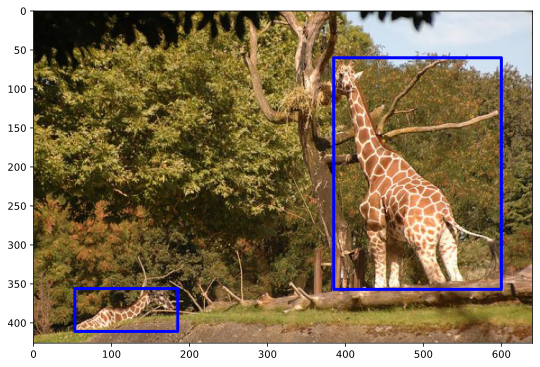

In [8]:
make_image_figure_with_bboxes(img, boxes)

**Resize Transform**

[(250.25, 58.59154929577465, 390.0, 348.61971830985914), (34.449999999999996, 347.6431924882629, 120.25, 401.3521126760564)]


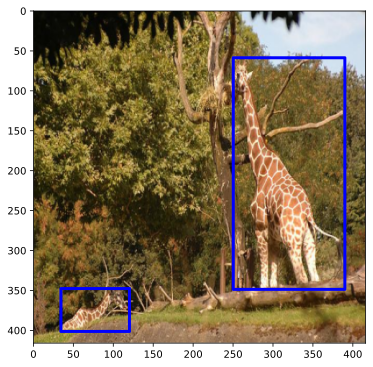

In [9]:
TARGET_HEIGHT = 416
TARGET_WIDTH = 416

resize_transform = A.Compose([
      A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),    
    ], bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    ))

resized_transform_result = resize_transform(
    image=img, bboxes=boxes, class_labels=[3, 3])

resized_image = resized_transform_result["image"]
resized_boxes = resized_transform_result["bboxes"]

print(resized_boxes)

make_image_figure_with_bboxes(
    resized_image, 
    BoundingBox.from_list_of_boxes(resized_boxes)
)

**Letter box (Preserves Aspect Ratio)**

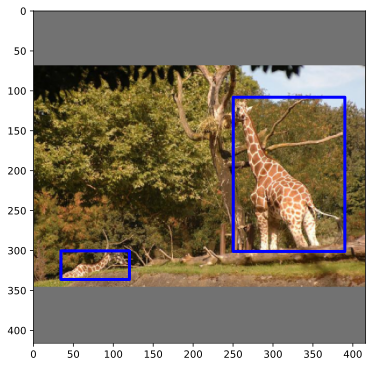

In [11]:
letter_box_transform = A.Compose([
    A.LongestMaxSize(max_size=TARGET_HEIGHT, interpolation=cv.INTER_LINEAR),
    A.PadIfNeeded(
        min_height=TARGET_HEIGHT,
        min_width=TARGET_HEIGHT,
        border_mode=cv.BORDER_CONSTANT,
        value=(114, 114, 114),
    ),
  ],bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    ))

letter_box_result = letter_box_transform(image=img, bboxes=boxes, class_labels=[3, 3])

letter_box_image = letter_box_result["image"]
letter_box_bboxes = letter_box_result["bboxes"]

make_image_figure_with_bboxes(
    letter_box_image, 
    BoundingBox.from_list_of_boxes(letter_box_bboxes))

**Horizontal flip**

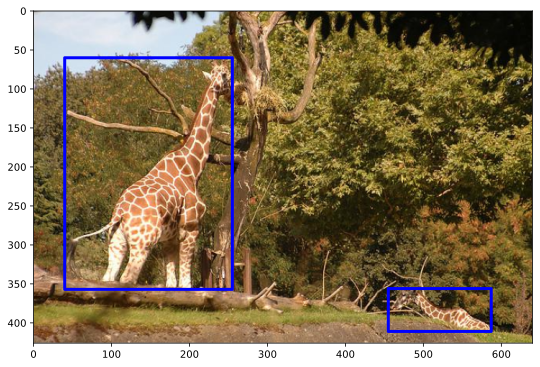

In [26]:
horizontal_flip_transform = A.Compose([
    A.HorizontalFlip(p=1.)
],bbox_params=A.BboxParams(
    format="pascal_voc",
    label_fields=["class_labels"],
))

horizontal_flipped_results = horizontal_flip_transform(image=img,bboxes=boxes, class_labels=[3, 3])
horizontal_flipped_results
make_image_figure_with_bboxes(horizontal_flipped_results["image"], BoundingBox.from_list_of_boxes(horizontal_flipped_results["bboxes"]))

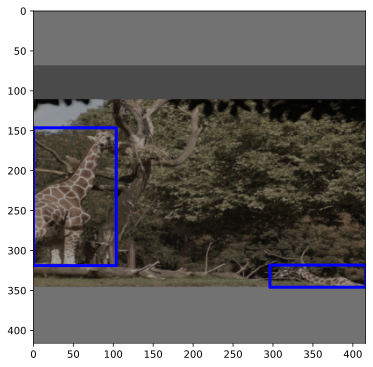

In [28]:
transform_pipeline = A.Compose([
    A.Affine(
        scale=(0.5, 1.5),
        translate_percent=(0.1, 0.1),
        rotate=0.0,
        shear=0.0,
        cval=(114, 114, 114),
        p=1.0,
    ),
    A.Blur(p=0.01),
    A.MedianBlur(p=0.01),
    A.ToGray(p=0.01),
    A.CLAHE(p=0.01),
    A.ColorJitter(
        contrast=0.0,
        saturation=0.7,
        hue=0.015,
        brightness=0.4,
    ),  
    A.HorizontalFlip(p=0.5),
    # letter box
    A.LongestMaxSize(max_size=TARGET_HEIGHT, interpolation=cv.INTER_LINEAR),
    A.PadIfNeeded(
      min_height=TARGET_HEIGHT,
      min_width=TARGET_HEIGHT,
      border_mode=cv.BORDER_CONSTANT,
      value=(114, 114, 114),
    ),
  ],bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    ))

transform_pipeline_result = transform_pipeline(image=img, bboxes=boxes, class_labels=[3, 3])

transformed_image = transform_pipeline_result["image"]
transformed_bboxes = transform_pipeline_result["bboxes"]

make_image_figure_with_bboxes(
    transformed_image, 
    BoundingBox.from_list_of_boxes(transformed_bboxes))



**Tensor transform**

In [29]:
from albumentations.pytorch import ToTensorV2

basic_transform = A.Compose([
    A.LongestMaxSize(max_size=TARGET_HEIGHT, interpolation=cv.INTER_LINEAR),
    A.PadIfNeeded(
        min_height=TARGET_HEIGHT,
        min_width=TARGET_HEIGHT,
        border_mode=cv.BORDER_CONSTANT,
        value=(114, 114, 114),
    ),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),
  ],bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    )
)          

basic_transform_result = basic_transform(image=img, bboxes=boxes, class_labels=[3, 3])

basic_transformed_image = basic_transform_result["image"]
basic_transformed_bboxes = basic_transform_result["bboxes"]
basic_transformed_labels = basic_transform_result["class_labels"]

basic_transformed_image.shape


torch.Size([3, 416, 416])